In [99]:
%load_ext autoreload
%autoreload 2

print 'Finished!'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Finished!


In [100]:

from solver_Lee import solve as lee_solve
from solver_440 import solve as new_solve
from seq_generator import SequencingGenerator as SeqGen
from seq_data import SequencingData
import numpy as np
from datetime import datetime

print 'Finished!'


Finished!


In [101]:

def assess_performance(results,data):
    pairs = results['cells']

    cells = data.metadata['cells']
    all_alphas, all_betas = zip(*cells)
    all_alphas,all_betas = set(all_alphas),set(all_betas)

    obs_alphas, obs_betas = zip(*data.well_data)
    obs_alphas, obs_betas = set(sum(obs_alphas, [])), set(sum(obs_betas, []))

    cells_set = set([(a,b) for a,b in cells])
    correct_pairs = [p for p in pairs if p in cells_set]
    incorrect_pairs = [p for p in pairs if p not in cells_set]

    pair_idxs = [cells.index(p) if p in cells else -1 for p in pairs]
    actual_freqs = [data.metadata['generated_data']['cell_frequencies'][i] if i!=-1 else 0.0 for i in pair_idxs]
    pred_freqs = results['cell_frequencies']
    pred_freqs_CI = results['cell_frequencies_CI']
    
    print "Solution statistics:"
    print "  Total cells (in system):", len(cells)
    print "  Number of alpha chains (in system):", len(all_alphas)
    print "  Number of beta chains (in system):", len(all_betas)
    print "  Number of alpha chains (observed):", len(obs_alphas)
    print "  Number of beta chains (observed):", len(obs_betas)
    print "  Total pairs identified:", len(pairs)
    print "  Correct pairs identified: {0} ({1}%)".format(len(correct_pairs), 100.*len(correct_pairs)/len(cells))
    print "  Incorrect pairs identified: {0}".format(len(incorrect_pairs))
    print "  False discovery rate: {0}%".format(100.*len(incorrect_pairs)/len(pairs))
    print "  Mean squared error of frequency guesses: {0}".format(np.mean([(f1-f2)**2 for f1,f2 in zip(actual_freqs, pred_freqs)]))



In [139]:

'''
Generate landscapes
'''

gen = SeqGen()

'''
Set distributions
'''

w_tot = 100

gen.set_cell_frequency_distribution('power-law', alpha=-0.5)
gen.set_options(chain_misplacement_prob=0,chain_deletion_prob=10**-1)
#gen.chain_misplacement_prob = 10**5 # Prob of a chain migrating to another well
#gen.chain_deletion_prob = 10**5 # Prob of a chain failing to be amplified

gen.num_wells = w_tot

# Make SequencingGenerator object
gen.set_cells_per_well('constant', cells_per_well=300)
#gen.set_cells_per_well('poisson', lam=100)

#gen.cells = SeqGen.generate_cells_lee(600)
cells = SeqGen.generate_cells(1000, 1, 2)
#cells += SeqGen.generate_cells(250, 2, 1, alpha_start_idx=250, beta_start_idx=251) 
#cells += SeqGen.generate_cells(250, 1, 2, alpha_start_idx=2000, beta_start_idx=2000) 
#gen.cells = cells

## Save data to a file
data = gen.generate_data()
data.save_data('patrick_testing.txt')

print 'Finished!'

Finished!


In [140]:
from solver_440 import solve as new_solve

startTime = datetime.now()
new_results = new_solve(data,pair_threshold=0.995,verbose=2) # not stringent
print 'PHASOR took {} seconds.\n'.format(datetime.now()-startTime)

startTime = datetime.now()
lee_results = lee_solve(data,pair_threshold=0.1) # not stringent
print 'Lee took {} seconds.\n'.format(datetime.now()-startTime)

print '\nPHASOR Performance:'
assess_performance(new_results,data)

print '\nLEE Performance:'
assess_performance(lee_results,data)

Starting image creation...
Starting edge detection...
Finished AB edges!
Finished BA edges!
Finished AA edges!
Finished BB edges!
Finished edge detection, analyzing graph...
Finished!
PHASOR took 0:00:07.877047 seconds.

Lee took 0:00:04.380273 seconds.... 100%


PHASOR Performance:
Solution statistics:
  Total cells (in system): 1000
  Number of alpha chains (in system): 1000
  Number of beta chains (in system): 1000
  Number of alpha chains (observed): 199
  Number of beta chains (observed): 200
  Total pairs identified: 150
  Correct pairs identified: 140 (14.0%)
  Incorrect pairs identified: 10
  False discovery rate: 6.66666666667%
  Mean squared error of frequency guesses: 0.0610703659805

LEE Performance:
Solution statistics:
  Total cells (in system): 1000
  Number of alpha chains (in system): 1000
  Number of beta chains (in system): 1000
  Number of alpha chains (observed): 199
  Number of beta chains (observed): 200
  Total pairs identified: 53
  Correct pairs identified: 40

In [133]:
print data.metadata['cells_per_well_distribution_params']['cells_per_well']
print data.metadata['num_wells']

100
100


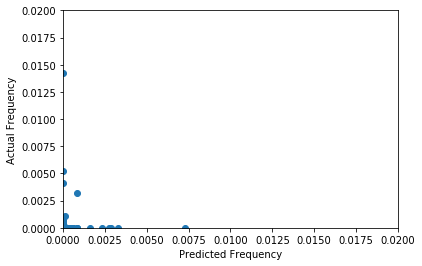

In [134]:

import matplotlib.pyplot as plt

predicted_freq = []

cells_per_well = data.metadata['cells_per_well_distribution_params']['cells_per_well']
wells = data.metadata['num_wells']

for c in data.metadata['cells']:
    if c in new_results['cells']:
        val = new_results['cell_frequencies'][new_results['cells'].index(c)]
        #predicted_freq.append(val)
        predicted_freq.append(1 - ((1-val)**(1./cells_per_well)))
    else:
        predicted_freq.append(0.)
        
plt.scatter(predicted_freq,data.metadata['generated_data']['cell_frequencies'])
plt.xlabel('Predicted Frequency')
plt.ylabel('Actual Frequency')
plt.xlim((0.,0.02))
plt.ylim((0.,0.02))
plt.show()
